In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet('../data/processed/ames_processed.parquet', engine='pyarrow')

X = df.drop('log_saleprice', axis=1)
y = df['log_saleprice']

In [3]:
bool_features = X.select_dtypes(include=['bool']).columns
X[bool_features] = X[bool_features].astype(int)

Train Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,lot_config,land_slope,bldg_type,...,all_exteriors_Stucco_Wd Sdng,all_exteriors_Stucco_Wd Shng,all_exteriors_Stucco_WdShing,all_exteriors_VinylSd,all_exteriors_VinylSd_Wd Sdng,all_exteriors_VinylSd_Wd Shng,all_exteriors_Wd Sdng,all_exteriors_Wd Sdng_Wd Shng,all_exteriors_Wd Sdng_WdShing,all_exteriors_Wd Shng_WdShing
1939,120,RM,44.0,4224,Pave,Reg,Lvl,Inside,Gtl,TwnhsE,...,0,0,0,0,0,0,0,0,0,0
212,20,RL,83.0,11980,Pave,Reg,Low,Inside,Mod,1Fam,...,0,0,0,0,0,0,0,0,0,0
1880,70,RL,53.0,6720,Pave,Reg,Lvl,Inside,Gtl,1Fam,...,0,0,0,1,0,0,0,0,0,0
787,70,RL,53.0,10918,Pave,Reg,Lvl,Inside,Gtl,1Fam,...,0,0,0,0,0,0,0,0,0,0
2165,60,RL,79.0,9462,Pave,Reg,Lvl,Inside,Gtl,1Fam,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,20,RL,60.0,11556,Pave,Reg,Lvl,Inside,Gtl,1Fam,...,0,0,0,0,0,0,0,0,0,0
1095,30,RM,60.0,6756,Pave,Reg,Lvl,Inside,Gtl,1Fam,...,0,0,0,0,0,0,0,0,0,0
1130,30,RM,50.0,6000,Pave,Reg,HLS,Inside,Gtl,1Fam,...,0,0,0,0,0,0,1,0,0,0
1294,50,RL,60.0,8400,Pave,Reg,Bnk,Inside,Gtl,1Fam,...,0,0,0,0,0,0,0,0,0,0


In [5]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['category']).columns

In [12]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [14]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

In [15]:
model = Ridge(alpha=1.0)
model_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [16]:
# Predict on test set
y_pred = model_pipeline.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")


Test RMSE: 0.112
Test R²: 0.911


c:\Users\SHRI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [19, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [17]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.3f}")

c:\Users\SHRI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [12, 23] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\SHRI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\SHRI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [9, 14, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\SHRI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [22, 24, 31] during transform. These unknown categories will be

Cross-validated R² scores: [0.87044789 0.89975262 0.91856433 0.9038017  0.90405433]
Mean CV R²: 0.899


c:\Users\SHRI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


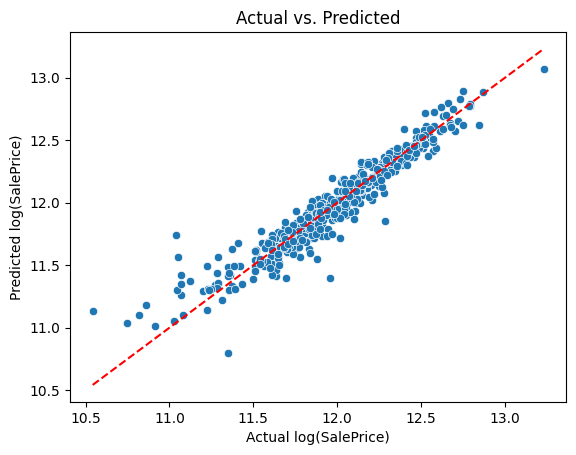

In [19]:
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual log(SalePrice)')
plt.ylabel('Predicted log(SalePrice)')
plt.title('Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.show()

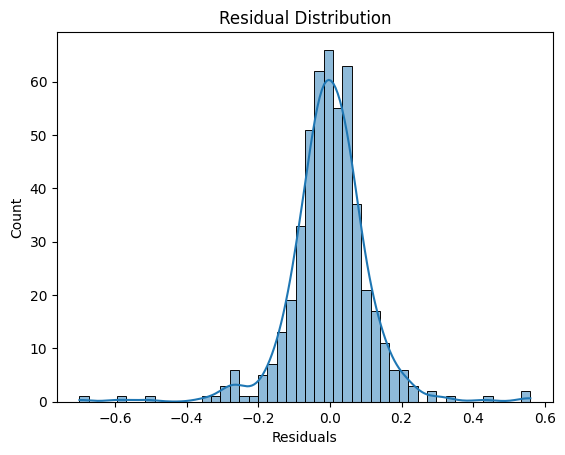

In [20]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.show()
